This Python notebook contains the code to reproduce the experiments in our [paper](https://arxiv.org/pdf/2003.06369.pdf):
> C. W. Combettes and S. Pokutta. Boosting Frank-Wolfe by Chasing Gradients. *arXiv preprint arXiv:2003.06369*, 2020.

The datasets `gisette_data.csv`, `gisette_labels.csv`, `movielens100k.csv`, and `aeroplane_data_small.mat` can be downloaded from [here](https://github.com/cyrillewcombettes/boostfw).

In [0]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from autograd import grad
from collections import Counter, defaultdict
from itertools import compress
from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from scipy.sparse.linalg import svds
from scipy.special import huber
from sklearn.preprocessing import StandardScaler
from time import process_time

import warnings
warnings.simplefilter('ignore')

# Oracles

In [0]:
def segment_search(f, grad_f, x, y, tol=1e-6, stepsize=True):
    
    '''
    Minimizes f over [x, y], i.e., f(x+gamma*(y-x)) as a function of scalar gamma in [0,1]
    '''
    
    # restrict segment of search to [x, y]
    d = (y-x).copy()
    left, right = x.copy(), y.copy()
    
    # if the minimum is at an endpoint
    if np.dot(d, grad_f(x))*np.dot(d, grad_f(y)) >= 0:
        if f(y) <= f(x):
            return y, 1
        else:
            return x, 0
    
    # apply golden-section method to segment
    gold = (1+np.sqrt(5))/2
    improv = np.inf
    while improv > tol:
        old_left, old_right = left, right
        new = left+(right-left)/(1+gold)
        probe = new+(right-new)/2
        if f(probe) <= f(new):
            left, right = new, right
        else:
            left, right = left, probe
        improv = np.linalg.norm(f(right)-f(old_right))+np.linalg.norm(f(left)-f(old_left))
    x_min = (left+right)/2
    
    # compute step size gamma
    gamma = 0
    if stepsize == True:
        for i in range(len(d)):
            if d[i] != 0:
                gamma = (x_min[i]-x[i])/d[i]
                break
                
    return x_min, gamma

def sigd(f, grad_f, x, S, alpha):
    
    '''
    Simplex Gradient Descent
    '''
    
    g = np.dot(S, grad_f(x))
    e, k = np.ones(len(S)), len(S)
    d = g-np.dot(g, e)*e/k
    
    if np.linalg.norm(d) == 0:
        return S[0], [S[0]], [1]
    
    eta = np.min([alpha[i]/d[i] if d[i] > 0 else np.inf for i in range(len(alpha))])
    beta = np.array(alpha)-eta*d
    y = np.dot(beta, S)

    if f(x) >= f(y):
        idx = list(beta > 0)
        return y, list(compress(S, idx)), list(compress(beta, idx))
    
    else:
        x, gamma = segment_search(f, grad_f, x, y)
        return x, S, list((1-gamma)*np.array(alpha)+gamma*beta)

def find_index(v, S):
    
    for i in range(len(S)):
        if np.all(S[i] == v):
            return i
        
    return -1

def align(d, hat_d):
    
    if np.linalg.norm(hat_d) < 1e-15:
        return -1
    
    else:
        return np.dot(d, hat_d)/(np.linalg.norm(d)*np.linalg.norm(hat_d))

# Algorithms

## FW, AFW

In [0]:
def fw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf):
    
    values, times, oracles, gaps = [f(x)], [0], [0], []
    f_improv = np.inf
    
    while f_improv > f_tol and np.sum(times) < time_tol:

        f_old = f(x)
        start = process_time()
        
        grad_f_x = grad_f(x)        
        v = lmo(grad_f_x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-v))
        t2 = process_time()

        if step == 't':
            gamma = 2/(len(values)+1)
            x = (1-gamma)*x+gamma*v
        elif step == 'L':
            gamma = min(np.dot(grad_f_x, x-v)/(L*np.linalg.norm(x-v)**2), 1)
            x = (1-gamma)*x+gamma*v
        elif step == 'ls':
            x, gamma = segment_search(f, grad_f, x, v)
        else:
            d = v-x
            gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), 1)
            x = x+gamma*d
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(1)
        f_improv = f_old-f(x)
        
    return x, values, times, oracles, gaps

def afw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf):
    
    values, times, oracles, gaps = [f(x)], [0], [0], []
    f_improv = np.inf
    S, alpha = [x.copy()], [1]
    
    while f_improv > f_tol and np.sum(times) < time_tol:
        
        f_old = f(x)        
        start = process_time()
                
        grad_f_x = grad_f(x)
        v = lmo(grad_f_x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-v))
        t2 = process_time()
        
        i_max = np.argmax(np.dot(S, grad_f_x))
        a = S[i_max]
        
        if np.dot(grad_f_x, v-x) <= np.dot(grad_f_x, x-a):
            if step == 'L':
                gamma = min(np.dot(grad_f_x, x-v)/(L*np.linalg.norm(x-v)**2), 1)
                x = (1-gamma)*x+gamma*v
            elif step == 'ls':
                x, gamma = segment_search(f, grad_f, x, v)
            else:
                d = v-x
                gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), 1)
                x = x+gamma*d
            S.append(v)
            alpha = list((1-gamma)*np.array(alpha))+[gamma]
        
        else:
            gamma_max = alpha[i_max]/(1-min(alpha[i_max], 0.99999))
            if step == 'L':
                gamma = min(np.dot(grad_f_x, a-x)/(L*np.linalg.norm(a-x)**2), gamma_max)
                x = (1+gamma)*x-gamma*a
                alpha = list((1+gamma)*np.array(alpha))
                alpha[i_max] -= gamma
                if gamma == gamma_max:
                    del alpha[i_max]
                    del S[i_max]
            elif step == 'ls':
                x, gamma = segment_search(f, grad_f, x, (1+gamma_max)*x-gamma_max*a)
                alpha = list((1+gamma*gamma_max)*np.array(alpha))
                alpha[i_max] -= gamma*gamma_max
                if gamma == 1:
                    del alpha[i_max]
                    del S[i_max]
            else:
                d = x-a
                gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), gamma_max)
                x = x+gamma*d
                alpha = list((1+gamma)*np.array(alpha))
                alpha[i_max] -= gamma
                if gamma == gamma_max:
                    del alpha[i_max]
                    del S[i_max]
                    
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(2)
        f_improv = f_old-f(x)

    return x, values, times, oracles, gaps

## BCG

In [0]:
def bcg(f, grad_f, x, step='ls', f_tol=1e-6, phi_tol=1e-6, time_tol=np.inf):
        
    values, times, oracles, gaps = [f(x)], [0], [0], []
    f_improv, phi_improv = np.inf, np.inf
    S, alpha = [x.copy()], [1]
    
    grad_f_x = grad_f(x)
    phi = np.dot(grad_f_x, x-lmo(grad_f_x))/2
    
    while (f_improv > f_tol or phi_improv > phi_tol) and np.sum(times) < time_tol:
        
        f_old, phi_old = f(x), phi
        start = process_time()
        
        grad_f_x = grad_f(x)
        grad_f_x_S = np.dot(S, grad_f_x)
        max_A_S, min_FW_S = max(grad_f_x_S), min(grad_f_x_S)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-lmo(grad_f_x)))
        t2 = process_time()
        
        if max_A_S-min_FW_S >= phi:
            x, S, alpha = sigd(f, grad_f, x, S, alpha)
        
        else:
            v = lmo(grad_f_x)
            grad_f_x_v = np.dot(grad_f_x, x-v)
            if grad_f_x_v < phi:
                phi = grad_f_x_v/2
            else:
                if step == 'ls':
                    x, gamma = segment_search(f, grad_f, x, v)
                else:
                    d = v-x
                    gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), 1)
                    x = x+gamma*d
                alpha = list((1-gamma)*np.array(alpha))
                idx = find_index(v, S)
                if idx == -1:
                    S.append(v)
                    alpha.append(0)
                    alpha[-1] += gamma
                else:
                    alpha[idx] += gamma
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(2)
        f_improv, phi_improv = f_old-f(x), abs(phi_old-phi)
    
    return x, values, times, oracles, gaps

## DICG

In [0]:
def dicg(f, grad_f, x, step='ls', f_tol=1e-6, time_tol=np.inf):
    
    values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
    f_improv = np.inf
    
    start = process_time()
    x = lmo(grad_f(x))
    end = process_time()
    values.append(f(x))
    times.append(end-start)
    oracles.append(1)
    
    while f_improv > f_tol and np.sum(times) < time_tol:
        
        f_old = f(x)        
        start = process_time()
        
        grad_f_x = grad_f(x)
        v = lmo(grad_f_x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-v))
        t2 = process_time()
        
        g = np.array([grad_f_x[i] if x[i] > 0 else -9e9 for i in range(len(x))])
        a = lmo(-g)
        
        d = v-a
        eta = np.min([-x[i]/d[i] if d[i] < 0 else np.inf for i in range(len(x))])
        eta = min(eta, 1)
        if step == 'ls':
            x, gamma = segment_search(f, grad_f, x, x+eta*d)
        else:
            gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), eta)
            x = x+gamma*d
        
        end = process_time()    
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(2)
        f_improv = f_old-f(x)
    
    return x, values, times, oracles, gaps

## BoostFW

In [0]:
def nnmp(x, grad_f_x, align_tol, K, traffic):
    
    '''
    Minimizes ||-grad_f_x-d||_2^2/2 s.t. d in cone(V-x)
    '''
    
    d, Lbd, flag = np.zeros(len(x)), 0, True
    
    G = grad_f_x+d
    align_d = align(-grad_f_x, d)
    
    for k in range(K):
        
        if traffic == True:
            G = np.maximum(G, 0)
        
        u = lmo(G)-x
        d_norm = np.linalg.norm(d)
        if d_norm > 0 and np.dot(G, -d/d_norm) < np.dot(G, u):
            u = -d/d_norm
            flag = False
        lbd = -np.dot(G, u)/np.linalg.norm(u)**2
        dd = d+lbd*u
        align_dd = align(-grad_f_x, dd)
        align_improv = align_dd-align_d
        
        if align_improv > align_tol:
            d = dd
            Lbd = Lbd+lbd if flag == True else Lbd*(1-lbd/d_norm)
            G = grad_f_x+d
            align_d = align_dd
            flag = True
            
        else:
            break
        
    return d/Lbd, k, align_d

def boostfw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf, align_tol=1e-3, K=500, traffic=False):
    
    if traffic == False:
        values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
        f_improv = np.inf

        start = process_time()
        x = lmo(grad_f(x))
        end = process_time()
        values.append(f(x))
        times.append(end-start)
        oracles.append(1)
    else:
        values, times, oracles, gaps = [f(x)], [0], [0], []
        f_improv = np.inf
    
    while f_improv > f_tol and np.sum(times) < time_tol:
                
        f_old = f(x)
        start = process_time()
        
        grad_f_x = grad_f(x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-lmo(grad_f_x)))
        t2 = process_time()
        
        g, num_oracles, align_g = nnmp(x, grad_f_x, align_tol, K, traffic)
        
        if step == 'L':
            gamma = min(align_g*np.linalg.norm(grad_f_x)/(L*np.linalg.norm(g)), 1)
            x = x+gamma*g
        elif step == 'ls':
            x, gamma = segment_search(f, grad_f, x, x+g)
        else:
            gamma = min(-np.dot(g, grad_f_x)/np.dot(g, (np.dot(step, g))), 1)
            x = x+gamma*g
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(num_oracles)
        f_improv = f_old-f(x)
        
    return x, values, times, oracles, gaps

## BoostDICG

In [0]:
def boostdicg(f, grad_f, x, step='ls', f_tol=1e-6, time_tol=np.inf, align_tol=1e-3, K=500, traffic=False):
    
    values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
    f_improv = np.inf
    
    start = process_time()
    x = lmo(grad_f(x))
    end = process_time()
    values.append(f(x))
    times.append(end-start)
    oracles.append(1)
    
    while f_improv > f_tol and np.sum(times) < time_tol:
        
        f_old = f(x)        
        start = process_time()
        
        grad_f_x = grad_f(x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-lmo(grad_f_x)))
        t2 = process_time()
        
        gg = np.array([grad_f_x[i] if x[i] > 0 else -9e9 for i in range(len(x))])
        a = lmo(-gg)
        
        g, num_oracles, align_g = nnmp(a, grad_f_x, align_tol, K, traffic)
                
        eta = np.min([-x[i]/g[i] if g[i] < 0 else np.inf for i in range(len(x))])
        eta = min(eta, 1)
        if step == 'ls':
            x, gamma = segment_search(f, grad_f, x, x+eta*g)
        else:
            gamma = min(-np.dot(g, grad_f_x)/np.dot(g, (np.dot(step, g))), eta)
            x = x+gamma*g
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(num_oracles+1)
        f_improv = f_old-f(x)
    
    return x, values, times, oracles, gaps

# Plotting

In [0]:
styles = {'afwls':'-', 'afwL':'--', 'bcg':'-', 'dicg':'-',
          'boostfwL':'--', 'boostfwls':'-', 'boostdicg':'-'}
colors = {'afwls':'tab:blue', 'afwL':'tab:blue', 'bcg':'tab:red', 'dicg':'tab:green',
          'boostfwL':'tab:orange', 'boostfwls':'tab:orange', 'boostdicg':'tab:purple'}
labels = {'afwls':'AFW-ls', 'afwL':'AFW-L', 'bcg':'BCG', 'dicg':'DICG',
          'boostfwL':'BoostFW-L', 'boostfwls':'BoostFW-ls', 'boostdicg':'BoostDICG'}

In [0]:
def plotter(res, styles, colors, labels, outfilename=None):
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(7)

    plt.subplot(1, 2, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][1])), res[alg][1], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function value')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 2, 2)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2]), res[alg][1], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def plotter_oracles(res, styles, colors, labels, outfilename=None):
    
    res_oracles = defaultdict(list)
    for alg in res.keys():
        for i in range(1, len(res[alg][1])):
            for j in range(res[alg][3][i]):
                res_oracles[alg].append(res[alg][1][i-1])
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(10)

    plt.subplot(1, 3, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][1])), res[alg][1], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function value')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 2)
    for alg in res.keys():
        plt.plot(np.arange(np.sum(res[alg][3])), res_oracles[alg], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('Oracle calls')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 3)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2]), res[alg][1], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def plotter_gaps(res, styles, colors, labels, outfilename=None):
    
    res_oracles = defaultdict(list)
    for alg in res.keys():
        for i in range(len(res[alg][4])):
            for j in range(res[alg][3][i+1]):
                res_oracles[alg].append(res[alg][4][i])
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(10)

    plt.subplot(1, 3, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][4])), res[alg][4], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Duality gap')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 2)
    for alg in res.keys():
        plt.plot(np.arange(np.sum(res[alg][3])), res_oracles[alg], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('Oracle calls')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 3)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2][1:]), res[alg][4], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def plotter_gaps_2(res, styles, colors, labels, outfilename=None):
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(7)

    plt.subplot(1, 2, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][4])), res[alg][4], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Duality gap')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 2, 2)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2][1:]), res[alg][4], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

# Computational experiments

## Figures 3 and 12: Sparse signal recovery

In [0]:
m, n, sigma = 200, 500, 0.05

x_star = np.random.randn(n)
A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)

f = lambda z: np.linalg.norm(y-np.dot(A, z[:n]-z[n:]), 2)**2
grad_f = grad(f)
L = 0 # not used

tau = np.linalg.norm(x_star, 1)
V = tau*np.identity(2*n)
x = V[np.random.randint(len(V))].copy()

lmo = lambda g: V[np.argmin(g)]

In [11]:
Q = np.matmul(np.transpose(A), A)
Q = 2*np.concatenate((np.concatenate((Q, -Q), axis=1), np.concatenate((-Q, Q), axis=1)), axis=0)

f_tol, time_tol, align_tol = 1e-6, 50, 1e-3

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol)
print('BCG')
res['bcg'] = bcg(f, grad_f, x, step=Q, f_tol=f_tol, time_tol=time_tol)
print('DICG')
res['dicg'] = dicg(f, grad_f, x, step=Q, f_tol=f_tol, time_tol=time_tol)
print('BoostFW')
res['boostfwls'] = boostfw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)

AFW-ls
BCG
DICG
BoostFW


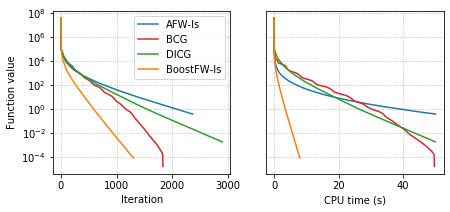

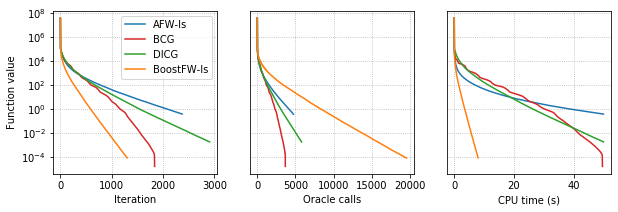

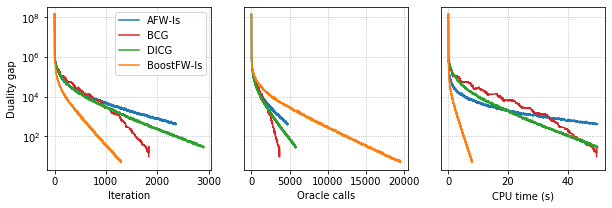

In [12]:
plotter(res, styles, colors, labels)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

## Figures 4 and 13: Sparse logistic regression on the Gisette dataset

In [0]:
A = pd.read_csv('gisette_data.csv', header=None)
y = pd.read_csv('gisette_labels.csv', header=None)[0].values

scaler = StandardScaler()
A = scaler.fit_transform(A)
m, n = A.shape

f = lambda z: np.sum(np.log(1+np.exp(-y*np.dot(A, z[:n]-z[n:]))))/m
grad_f = grad(f)
L = 0.5

tau = 10
V = tau*np.identity(2*n)
x = V[np.random.randint(len(V))].copy()

lmo = lambda g: V[np.argmin(g)]

In [27]:
f_tol, time_tol, align_tol = 1e-6, 80, 1e-4

res = {}

print('AFW-L')
res['afwL'] = afw(f, grad_f, L, x, step='L', f_tol=-1, time_tol=20)
print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BCG')
res['bcg'] = bcg(f, grad_f, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('DICG')
res['dicg'] = dicg(f, grad_f, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BoostFW-L')
res['boostfwL'] = boostfw(f, grad_f, L, x, step='L', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)

AFW-L
AFW-ls
BCG
DICG
BoostFW-L
BoostFW-ls


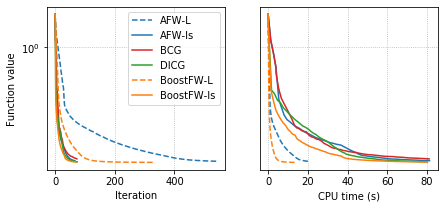

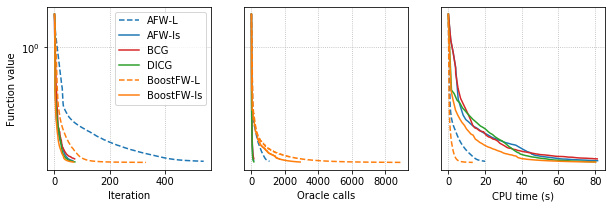

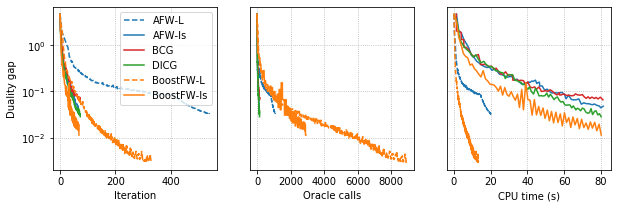

In [28]:
plotter(res, styles, colors, labels)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

## Figures 5 and 14: Traffic assignment problem

In [0]:
m, n, p = 25, 20, 0.5
mn = m*n

vertices = np.arange(mn)

DG = nx.DiGraph()

for i in vertices[:-m]:
    l = i//m
    for h in range(m):
        if np.random.binomial(1, p) == 1:
            DG.add_edge(i, (l+1)*m+h)

out_neighbors = defaultdict(list)
for i, j in DG.edges:
    out_neighbors[i].append(j)

OD = []
for s in vertices:
    OD.extend([(s, j) for j in out_neighbors[s]])
    queue = out_neighbors[s].copy()
    dequeued = []
    while len(queue) > 0:
        i = queue[0]
        dequeued.append(i)
        queue = queue[1:]
        for j in out_neighbors[i]:
            if j not in dequeued and j not in queue:
                OD.append((s, j))
                queue.append(j)

demands = {}
for i, j in OD:
    demands[i, j] = np.random.random()

def lmo(g):
    
    v = np.zeros((mn, mn))
    
    weights = np.reshape(g, (mn, mn))
    for i in out_neighbors.keys():
        for j in out_neighbors[i]:
            DG[i][j]['weight'] = weights[i][j]
    
    paths = dict(nx.all_pairs_dijkstra_path(DG))
    
    for s, t in OD:
        path = paths[s][t]
        for idx in range(len(path)-1):
            v[path[idx], path[idx+1]] += demands[s, t]
    
    return np.reshape(v, mn**2)

c = len(OD)/(m*n)

def f(x):
    X = np.reshape(x, (mn, mn))
    return sum([X[i, j]+0.03*X[i, j]**5/c**4 for i, j in DG.edges])/(mn**2)

grad_f = grad(f)

L = 0 # not used
x = lmo(np.random.random(mn**2))

In [30]:
f_tol, time_tol, align_tol = 1e-6, 120, 1e-3

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BCG')
res['bcg'] = bcg(f, grad_f, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, 
                           align_tol=align_tol, K=5, traffic=True)

AFW-ls
BCG
BoostFW-ls


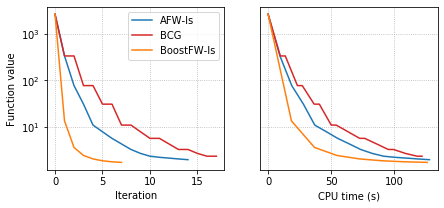

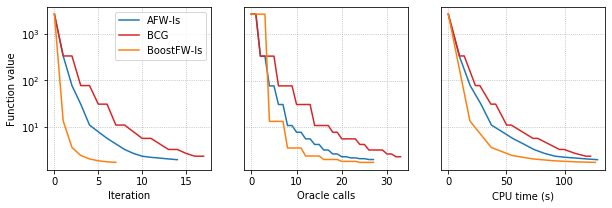

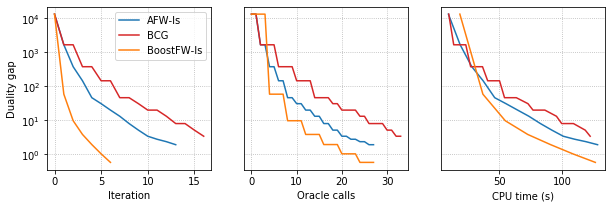

In [31]:
plotter(res, styles, colors, labels)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

## Figures 6 and 15: Collaborative filtering on the MovieLens 100k dataset

In [0]:
data = pd.read_csv('movielens100k.csv', names=['user id', 'item id', 'rating', 'timestamp'])
Y = pd.pivot_table(data, values='rating', index='user id', columns='item id').values
m, n = Y.shape

mn = m*n
y = np.reshape(Y, mn)
N = np.sum(~np.isnan(y))

rho = 1
f = lambda x: np.sum(huber(rho, np.nan_to_num(y-x)))/N
der_huber = np.vectorize(lambda t, rho: t if abs(t) <= rho else rho if t > rho else -rho)
grad_f = lambda x: -der_huber(np.nan_to_num(y-x), rho)/N
L = 5e-6

tau = 5000
x = tau*np.reshape(np.outer(np.identity(m)[0], np.identity(n)[0]), mn)

def lmo(g):
    
    G = np.reshape(-g, (m, n))
    u, s, v = svds(G, k=1, which='LM')
    
    return np.reshape(tau*np.outer(u, v), len(g))

In [37]:
f_tol, time_tol, align_tol = 1e-6, 500, 1e-3

# res = {}

print('AFW-L')
# res['afwL'] = afw(f, grad_f, L, x, step='L', f_tol=-1, time_tol=250)
print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BCG')
# res['bcg'] = bcg(f, grad_f, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BoostFW-L')
# res['boostfwL'] = boostfw(f, grad_f, L, x, step='L', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)
print('BoostFW-ls')
# res['boostfwls'] = boostfw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)

AFW-L
AFW-ls
BCG
BoostFW-L
BoostFW-ls


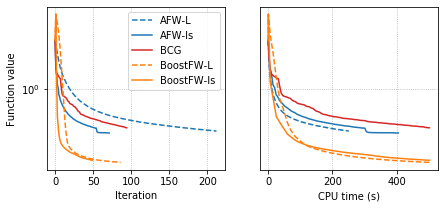

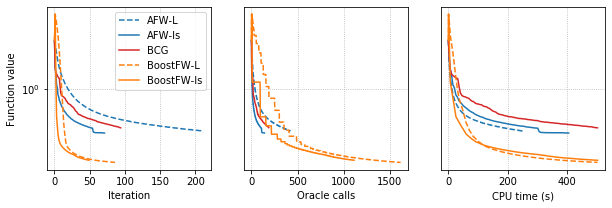

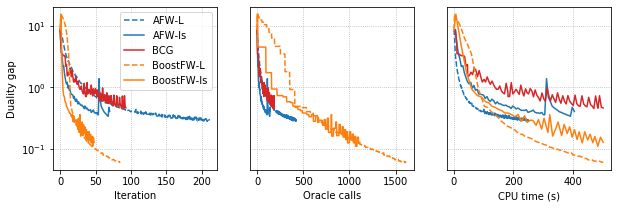

In [38]:
plotter(res, styles, colors, labels)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

## Figures 7, 8, and 16: Video co-localization on the YouTube-Objects dataset

$5$ videos, $20$ boxes per frame, $33$ frames in total, $660$ boxes in total.

| Video | Frames per video | Boxes per video |
| - | - | - |
| 1 | $8$ | $160$ |
| 2 | $7$ | $140$ |
| 3 | $7$ | $140$ |
| 4 | $4$ | $80$ |
| 5 | $7$ | $140$ |

In [0]:
data = loadmat('aeroplane_data_small.mat')
A, b = data['A'], np.array([data['b'][i][0] for i in range(data['b'].shape[0])])

f = lambda x: np.dot(x, np.dot(A, x))/2+np.dot(b, x)
grad_f = lambda x: np.dot(A, x)+b
L = 0 # not used

I = np.identity(20)
x = np.concatenate([np.array([1]+[0]*19) for i in range(33)], axis=0)

lmo = lambda g: np.concatenate([I[np.argmin(g[20*i:20*i+20])] for i in range(33)], axis=0)

In [40]:
f_tol, time_tol = -1, 0.04

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('BCG')
res['bcg'] = bcg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('DICG')
res['dicg'] = dicg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step=A, f_tol=f_tol, time_tol=time_tol, align_tol=1e-7)
print('BoostDICG')
res['boostdicg'] = boostdicg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol, align_tol=1e-15)

AFW-ls
BCG
DICG
BoostFW-ls
BoostDICG


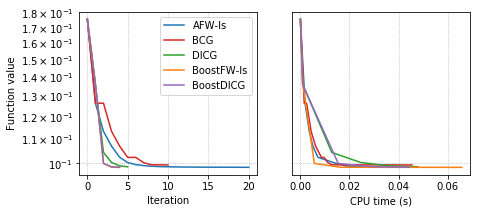

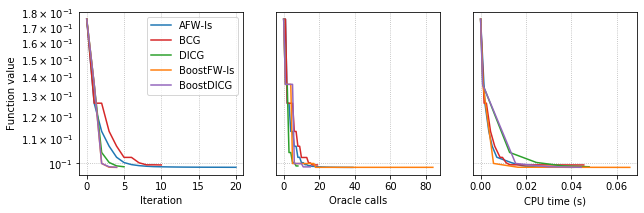

In [41]:
plotter(res, styles, colors, labels)
plotter_oracles(res, styles, colors, labels)

In [42]:
f_tol, time_tol = -1, 3

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('BCG')
res['bcg'] = bcg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('DICG')
res['dicg'] = dicg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step=A, f_tol=f_tol, time_tol=time_tol, align_tol=1e-7)
print('BoostDICG')
res['boostdicg'] = boostdicg(f, grad_f, x, step=A, f_tol=f_tol, time_tol=time_tol, align_tol=1e-15)

AFW-ls
BCG
DICG
BoostFW-ls
BoostDICG


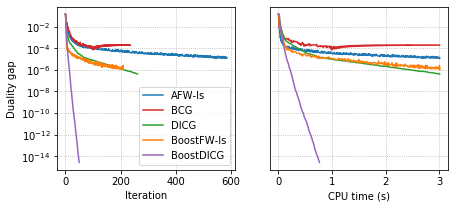

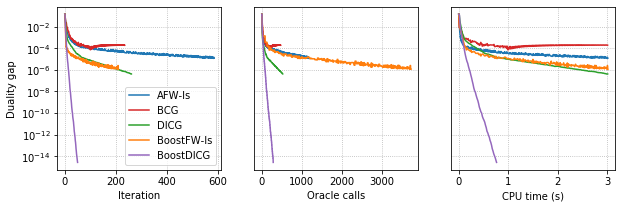

In [43]:
plotter_gaps_2(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

## Figure 9: Lower bound on the number of oracle calls

In [0]:
n = 1000

f = lambda x: np.linalg.norm(x)**2
grad_f = lambda x: 2*x
L = 2

I = np.identity(n)
x = I[0].copy()

lmo = lambda g: I[np.argmin(g)]

In [0]:
Q = 2*I

f_tol, time_tol, align_tol = 1e-6, 3, 1e-3

res = {}

res['fwls'] = fw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol)
res['boostfwls'] = boostfw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)

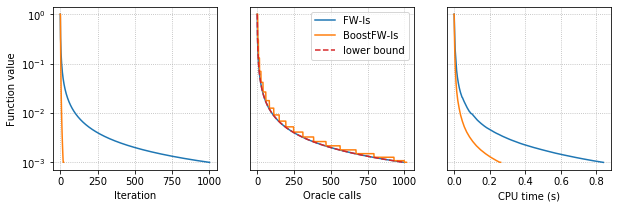

In [46]:
colorz = {'fwls':'tab:blue', 'boostfwls':'tab:orange'}
labelz = {'fwls':'FW-ls', 'boostfwls':'BoostFW-ls'}

res_oracles = defaultdict(list)
for alg in res.keys():
    for i in range(1, len(res[alg][1])):
        for j in range(res[alg][3][i]):
            res_oracles[alg].append(res[alg][1][i-1])

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(10)

plt.subplot(1, 3, 1)
for alg in res.keys():
    plt.plot(np.arange(len(res[alg][1])), res[alg][1], color=colorz[alg])
plt.yscale('log')
plt.ylabel('Function value')
plt.xlabel('Iteration')
plt.tick_params(which='minor', left=False)
plt.grid(linestyle=':')

plt.subplot(1, 3, 2)
for alg in res.keys():
    plt.plot(np.arange(np.sum(res[alg][3])), res_oracles[alg], color=colorz[alg], label=labelz[alg])
plt.plot(np.arange(n), [1/(t+1) for t in np.arange(n)], linestyle='--', color='tab:red',
         label='lower bound')
plt.legend()
plt.yscale('log')
plt.xlabel('Oracle calls')
plt.tick_params(which='both', left=False, labelleft=False)
plt.grid(linestyle=':')

plt.subplot(1, 3, 3)
for alg in res.keys():
    plt.plot(np.cumsum(res[alg][2]), res[alg][1], color=colorz[alg])
plt.yscale('log')
plt.xlabel('CPU time (s)')
plt.tick_params(which='both', left=False, labelleft=False)
plt.grid(linestyle=':')

plt.show()

## Figures 10 and 11: Relative improvements in alignment during the gradient pursuit procedure of BoostFW

In [0]:
def nnmp0(x, grad_f_x, align_tol, K, align_rounds1, align_rounds2, traffic):
    
    d, Lbd, flag = np.zeros(len(x)), 0, True
    
    G = grad_f_x+d
    align_d = align(-grad_f_x, d)
    
    for k in range(K):
        
        if traffic == True:
            G = np.maximum(G, 0)
        
        u = lmo(G)-x
        d_norm = np.linalg.norm(d)
        if d_norm > 0 and np.dot(G, -d/d_norm) < np.dot(G, u):
            u = -d/d_norm
            flag = False
        lbd = -np.dot(G, u)/np.linalg.norm(u)**2
        dd = d+lbd*u
        align_dd = align(-grad_f_x, dd)
        align_improv = align_dd-align_d
        
        if align_improv > align_tol:
            d = dd
            Lbd = Lbd+lbd if flag == True else Lbd*(1-lbd/d_norm)
            align_rounds1[k+1] += align_improv/align_d
            align_rounds2[k+1] += (align_improv/align_d)**2
            G = grad_f_x+d
            align_d = align_dd
            flag = True
            
        else:
            break
        
    return d/Lbd, k, align_d, align_rounds1, align_rounds2

def boostfw0(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf, align_tol=1e-3, K=500, traffic=False):
    
    if traffic == False:
        values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
        f_improv = np.inf

        start = process_time()
        x = lmo(grad_f(x))
        end = process_time()
        values.append(f(x))
        times.append(end-start)
        oracles.append(1)
    else:
        values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
        f_improv = np.inf

    align_rounds1, align_rounds2 = defaultdict(int), defaultdict(int)
    
    while f_improv > f_tol and np.sum(times) < time_tol:
                
        f_old = f(x)
        start = process_time()
        
        grad_f_x = grad_f(x)
        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-lmo(grad_f_x)))
        t2 = process_time()
        
        g, num_oracles, align_g, align_rounds1, align_rounds2 = nnmp0(x, grad_f_x, align_tol, K,
                                                                      align_rounds1, align_rounds2, traffic)
        
        if step == 'L':
            gamma = min(align_g*np.linalg.norm(grad_f_x)/(L*np.linalg.norm(g)), 1)
            x = x+gamma*g
        elif step == 'ls':
            x, gamma = segment_search(f, grad_f, x, x+g)
        else:
            gamma = min(-np.dot(g, grad_f_x)/np.dot(g, (np.dot(step, g))), 1)
            x = x+gamma*g
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(num_oracles)
        f_improv = f_old-f(x)
        
    return x, values, times, oracles, gaps, align_rounds1, align_rounds2

### Figure 10

In [0]:
m, n, sigma = 200, 500, 0.05

x_star = np.random.randn(n)
A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)

f = lambda z: np.linalg.norm(y-np.dot(A, z[:n]-z[n:]), 2)**2
grad_f = grad(f)
L = 0 # not used

tau = np.linalg.norm(x_star, 1)
V = tau*np.identity(2*n)
x = V[np.random.randint(len(V))].copy()

lmo = lambda g: V[np.argmin(g)]

In [0]:
Q = np.matmul(np.transpose(A), A)
Q = 2*np.concatenate((np.concatenate((Q, -Q), axis=1), np.concatenate((-Q, Q), axis=1)), axis=0)

f_tol, time_tol, align_tol = 1e-6, 50, 1e-3

res = {}

res['boostfwls'] = boostfw0(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)

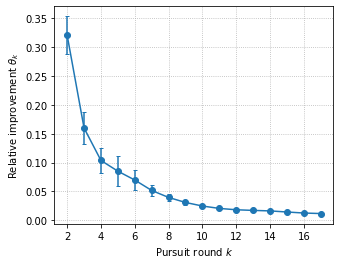

In [50]:
freqs = Counter(res['boostfwls'][3][1:]) # number of iterations where there were x updates
means_improv_per_update, stds_improv_per_update = {}, {}
m, M = min(freqs.keys()), max(freqs.keys())
for k, s in res['boostfwls'][5].items(): # k, s: update number, sum of align improvements
    means_improv_per_update[k] = s/np.sum([freqs[kk] for kk in range(max(k, m), M+1)])
for k, s2 in res['boostfwls'][6].items(): # k, s2: update number, sum of squared align improvements
    stds_improv_per_update[k] = np.sqrt(s2/np.sum([freqs[kk] for kk in range(max(k, m), M+1)])\
    -means_improv_per_update[k]**2)

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)

plt.errorbar(list(means_improv_per_update.keys())[1:], list(means_improv_per_update.values())[1:], 
             yerr=list(stds_improv_per_update.values())[1:], fmt='-o', capsize=2)
plt.ylabel(r'Relative improvement $\theta_k$')
plt.xlabel(r'Pursuit round $k$')
plt.grid(linestyle=':')
plt.show()

### Figure 11

In [0]:
m, n, p = 25, 20, 0.5
mn = m*n

vertices = np.arange(mn)

DG = nx.DiGraph()

for i in vertices[:-m]:
    l = i//m
    for h in range(m):
        if np.random.binomial(1, p) == 1:
            DG.add_edge(i, (l+1)*m+h)

out_neighbors = defaultdict(list)
for i, j in DG.edges:
    out_neighbors[i].append(j)

OD = []
for s in vertices:
    OD.extend([(s, j) for j in out_neighbors[s]])
    queue = out_neighbors[s].copy()
    dequeued = []
    while len(queue) > 0:
        i = queue[0]
        dequeued.append(i)
        queue = queue[1:]
        for j in out_neighbors[i]:
            if j not in dequeued and j not in queue:
                OD.append((s, j))
                queue.append(j)

demands = {}
for i, j in OD:
    demands[i, j] = np.random.random()

def lmo(g):
    
    v = np.zeros((mn, mn))
    
    weights = np.reshape(g, (mn, mn))
    for i in out_neighbors.keys():
        for j in out_neighbors[i]:
            DG[i][j]['weight'] = weights[i][j]
    
    paths = dict(nx.all_pairs_dijkstra_path(DG))
    
    for s, t in OD:
        path = paths[s][t]
        for idx in range(len(path)-1):
            v[path[idx], path[idx+1]] += demands[s, t]
    
    return np.reshape(v, mn**2)

c = len(OD)/(m*n)

def f(x):
    X = np.reshape(x, (mn, mn))
    return sum([X[i, j]+0.03*X[i, j]**5/c**4 for i, j in DG.edges])/(mn**2)

grad_f = grad(f)

L = 0 # not used
x = lmo(np.random.random(mn**2))

In [0]:
f_tol, time_tol, align_tol = 1e-6, 100, 1e-3

res = {}

res['boostfwls'] = boostfw0(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, 
                            align_tol=align_tol, K=15, traffic=True)

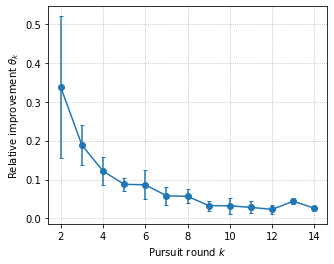

In [53]:
freqs = Counter(res['boostfwls'][3][1:]) # number of iterations where there were x updates
means_improv_per_update, stds_improv_per_update = {}, {}
m, M = min(freqs.keys()), max(freqs.keys())
for k, s in res['boostfwls'][5].items(): # k, s: update number, sum of align improvements
    if k <= M:
        means_improv_per_update[k] = s/np.sum([freqs[kk] for kk in range(max(k, m), M+1)])
for k, s2 in res['boostfwls'][6].items(): # k, s2: update number, sum of squared align improvements
    if k <= M:
        stds_improv_per_update[k] = np.sqrt(s2/np.sum([freqs[kk] for kk in range(max(k, m), M+1)])\
                                            -means_improv_per_update[k]**2)

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)

plt.errorbar(list(means_improv_per_update.keys())[1:], list(means_improv_per_update.values())[1:], 
             yerr=list(stds_improv_per_update.values())[1:], fmt='-o', capsize=2)
plt.ylabel(r'Relative improvement $\theta_k$')
plt.xlabel(r'Pursuit round $k$')
plt.grid(linestyle=':')
plt.show()